# Load your dataset

Example data for one frame:
```
{
    "./sampledFrames/test_video/13260.jpg": 
    {
        "subject": ["man", "man", "glass", "window", "man"], 
        "relation": ["wearing", "wearing", "on", "on", "has"], 
        "object": ["glass", "shirt", "face", "car", "hair"], 
        "triplet": ["man wearing glass", "man wearing shirt", "glass on face", "window on car", "man has hair"]
    }
}
```

In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np

import lib.driving_dataset.DrivingDataset as DrivingDataset
import lib.driving_dataset.Preprocessor as Preproc

import importlib
importlib.reload(DrivingDataset)
importlib.reload(Preproc)

preproc = Preproc.Preprocessor()

dataset = preproc.loadSceneGraphData('test_video')
data = dataset.iloc[0, 0]
print(data)
print('==============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_attr)

/home/ashmitchamoli/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(
  x=[9, 1],
  edge_index=[2, 6],
  edge_attr=[6, 1],
  num_nodes=9,
  num_features=1,
  nodeIndex={
    glass=0,
    boy=1,
    man=2,
    window=3,
    hair=4,
    face=5,
    shirt=6,
    car=7,
    woman=8,
  },
  edgeAttributeIndex={
    on=0,
    wearing=1,
    has=2,
  }
)
Number of nodes: 9
Number of edges: 6
Average node degree: 0.67
Has isolated nodes: False
Has self-loops: False
Is undirected: False
tensor([[0, 1, 1, 2, 3, 4],
        [5, 6, 4, 0, 7, 8]])
tensor([[0],
        [1],
        [2],
        [1],
        [0],
        [0]])


In [2]:
# sceneGraphData = preproc.loadSceneGraphData('test_video')
# sceneGraphData

In [3]:
# imageEmbeddingData = preproc.loadImageEmbeddings('test_video')
# imageEmbeddingData

In [4]:

# preproc.loadAllData('test_video')

In [5]:
drivingDataset = DrivingDataset.DrivingDataset('test_video')
i = np.random.randint(0, len(drivingDataset))

In [6]:
print(f"Embedding Size: {drivingDataset[0][0][1].shape[0]}")
drivingDataset[0]

Embedding Size: 25088


([Data(
    x=[9, 1],
    edge_index=[2, 6],
    edge_attr=[6, 1],
    num_nodes=9,
    num_features=1,
    nodeIndex={
      glass=0,
      boy=1,
      man=2,
      window=3,
      hair=4,
      face=5,
      shirt=6,
      car=7,
      woman=8,
    },
    edgeAttributeIndex={
      on=0,
      wearing=1,
      has=2,
    }
  ),
  tensor([0.0573, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]),
  tensor([0])],
 tensor(4))

{'on': 0, 'wearing': 1, 'has': 2}


/home/ashmitchamoli/.local/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


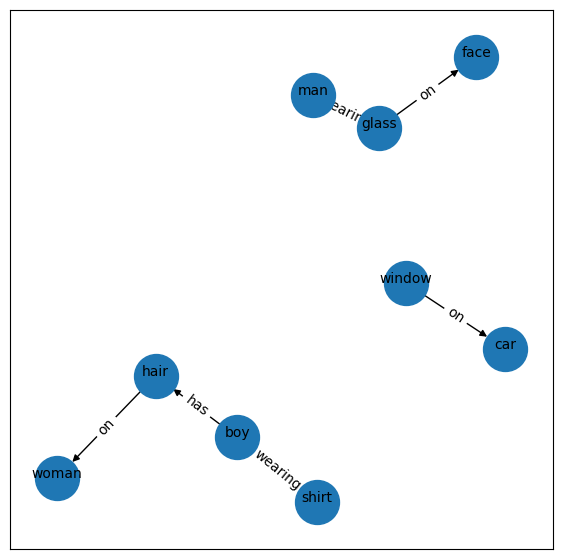

In [7]:
from torch_geometric.utils import to_networkx
import networkx as nx

sceneGraph = dataset.iloc[0, 0]

def visualize_graph(G, color, nodeLabel, edgeLabels):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos, with_labels=False,
                     node_color=color, cmap="Set2", node_size=1000, )
    # write labels on edges
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgeLabels)
    
    # write labels on nodes
    for k, v in pos.items():
        plt.text(v[0], v[1], s=nodeLabel[k],
                 horizontalalignment='center', fontsize=10)
    plt.show()

G = to_networkx(sceneGraph, 
                to_undirected=False)

print(sceneGraph.edgeAttributeIndex)
visualize_graph(G,
                color=data.y, 
                nodeLabel={sceneGraph.nodeIndex[k]: k for k in sceneGraph.nodeIndex},
                edgeLabels=dict([((n1, n2), {v : k for k, v in sceneGraph.edgeAttributeIndex.items()}[int(k[0])]) for k, (n1, n2) in zip(sceneGraph.edge_attr, G.edges)]))

# GNN

In [8]:
import lib.models.GNN as GNN
importlib.reload(GNN)

model = GNN.GNN(dataset.iloc[0, 0].num_features, embeddingSize=2)
print(model)

i = np.random.randint(0, len(dataset.index))

graphEmbedding = model(dataset.iloc[i, 0].x, dataset.iloc[i, 0].edge_index)
# graph_embedding = scatter_mean(h, dataset.batch, dim=0)
print(graphEmbedding)

GNN(
  (convLayers): Sequential(
    (0): GCNConv(1, 2)
  )
  (conv1): GCNConv(1, 2)
  (nodeAggregator): MeanAggregation()
)
tensor([[ 2.0521, -8.1559]], grad_fn=<DivBackward0>)


In [9]:
import lib.models.CombinerModel as CombinerModel
importlib.reload(CombinerModel)

model = CombinerModel.CombinerModel(dataset.iloc[0, 0].num_features,
                                    sceneGraphEmbeddingSize=8,
                                    imgEmbeddingSize=drivingDataset.imageEmbeddingSize,
                                    reducedImgEmbeddingSize=64,
                                    encoderHiddenLayers=[64, 32],
                                    numClasses=drivingDataset.numClasses,
                                    n_peripheralInputs=1,
                                    feedForwardHiddenLayers=[64, 32])
print(model)

CombinerModel(
  (sceneGraphBlock): GNN(
    (convLayers): Sequential(
      (0): GCNConv(1, 8)
    )
    (conv1): GCNConv(1, 8)
    (nodeAggregator): MeanAggregation()
  )
  (ffnnClassifierBlock): LinearClassifier(
    (imgEmbeddingEncoder): Sequential(
      (0): Linear(in_features=25088, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
    (feedForwardLayer): Sequential(
      (0): Linear(in_features=73, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=18, bias=True)
      (3): Softmax(dim=0)
    )
  )
)


In [10]:
model.train(drivingDataset, lr=0.001, epochs=100)

Training: 100%|██████████| 106/106 [00:01<00:00, 58.17it/s]


Epoch 1 Loss: 2.8537813053940826


Training: 100%|██████████| 106/106 [00:00<00:00, 231.39it/s]


Epoch 2 Loss: 2.7983970484643614


Training: 100%|██████████| 106/106 [00:00<00:00, 233.55it/s]


Epoch 3 Loss: 2.7805616180851773


Training: 100%|██████████| 106/106 [00:00<00:00, 230.87it/s]


Epoch 4 Loss: 2.863229084689662


Training: 100%|██████████| 106/106 [00:00<00:00, 235.67it/s]


Epoch 5 Loss: 2.798655574051839


Training: 100%|██████████| 106/106 [00:00<00:00, 205.34it/s]


Epoch 6 Loss: 2.7620491048075118


Training: 100%|██████████| 106/106 [00:00<00:00, 236.88it/s]


Epoch 7 Loss: 2.6726804589325526


Training: 100%|██████████| 106/106 [00:00<00:00, 228.94it/s]


Epoch 8 Loss: 2.660654900208959


Training: 100%|██████████| 106/106 [00:00<00:00, 229.04it/s]


Epoch 9 Loss: 2.642111874976248


Training: 100%|██████████| 106/106 [00:00<00:00, 235.33it/s]


Epoch 10 Loss: 2.7213200341980412


Training: 100%|██████████| 106/106 [00:00<00:00, 236.45it/s]


Epoch 11 Loss: 2.735791155752146


Training: 100%|██████████| 106/106 [00:00<00:00, 220.95it/s]


Epoch 12 Loss: 2.6847716513669715


Training: 100%|██████████| 106/106 [00:00<00:00, 227.30it/s]


Epoch 13 Loss: 2.641039939421528


Training: 100%|██████████| 106/106 [00:00<00:00, 232.60it/s]


Epoch 14 Loss: 2.6323228186031558


Training: 100%|██████████| 106/106 [00:00<00:00, 231.01it/s]


Epoch 15 Loss: 2.615761054012011


Training: 100%|██████████| 106/106 [00:00<00:00, 208.36it/s]


Epoch 16 Loss: 2.610314669474116


Training: 100%|██████████| 106/106 [00:00<00:00, 223.78it/s]


Epoch 17 Loss: 2.810727490569061


Training: 100%|██████████| 106/106 [00:00<00:00, 234.86it/s]


Epoch 18 Loss: 2.8097596730826035


Training: 100%|██████████| 106/106 [00:00<00:00, 225.83it/s]


Epoch 19 Loss: 2.809679393498403


Training: 100%|██████████| 106/106 [00:00<00:00, 230.72it/s]


Epoch 20 Loss: 2.8091976597624004


Training: 100%|██████████| 106/106 [00:00<00:00, 231.54it/s]


Epoch 21 Loss: 2.8084859623099274


Training: 100%|██████████| 106/106 [00:00<00:00, 220.79it/s]


Epoch 22 Loss: 2.8082754229599574


Training: 100%|██████████| 106/106 [00:00<00:00, 224.44it/s]


Epoch 23 Loss: 2.8078242056774645


Training: 100%|██████████| 106/106 [00:00<00:00, 233.13it/s]


Epoch 24 Loss: 2.8223046300546177


Training: 100%|██████████| 106/106 [00:00<00:00, 228.27it/s]


Epoch 25 Loss: 2.750246417972277


Training: 100%|██████████| 106/106 [00:00<00:00, 216.46it/s]


Epoch 26 Loss: 2.821299358358923


Training: 100%|██████████| 106/106 [00:00<00:00, 238.30it/s]


Epoch 27 Loss: 2.811734975508924


Training: 100%|██████████| 106/106 [00:00<00:00, 211.11it/s]


Epoch 28 Loss: 2.811734973259692


Training: 100%|██████████| 106/106 [00:00<00:00, 223.90it/s]


Epoch 29 Loss: 2.811734973259692


Training: 100%|██████████| 106/106 [00:00<00:00, 223.49it/s]


Epoch 30 Loss: 2.811734973259692


Training: 100%|██████████| 106/106 [00:00<00:00, 233.80it/s]


Epoch 31 Loss: 2.811734973259692


Training: 100%|██████████| 106/106 [00:00<00:00, 232.25it/s]


Epoch 32 Loss: 2.811734973259692


Training: 100%|██████████| 106/106 [00:00<00:00, 230.66it/s]


Epoch 33 Loss: 2.81173497101046


Training: 100%|██████████| 106/106 [00:00<00:00, 227.75it/s]


Epoch 34 Loss: 2.811734968761228


Training: 100%|██████████| 106/106 [00:00<00:00, 220.97it/s]


Epoch 35 Loss: 2.811734966511996


Training: 100%|██████████| 106/106 [00:00<00:00, 231.91it/s]


Epoch 36 Loss: 2.811734968761228


Training: 100%|██████████| 106/106 [00:00<00:00, 211.83it/s]


Epoch 37 Loss: 2.811734966511996


Training: 100%|██████████| 106/106 [00:00<00:00, 227.02it/s]


Epoch 38 Loss: 2.811734966511996


Training: 100%|██████████| 106/106 [00:00<00:00, 232.23it/s]


Epoch 39 Loss: 2.811734966511996


Training: 100%|██████████| 106/106 [00:00<00:00, 234.75it/s]


Epoch 40 Loss: 2.8117349642627643


Training: 100%|██████████| 106/106 [00:00<00:00, 233.05it/s]


Epoch 41 Loss: 2.811734957515069


Training: 100%|██████████| 106/106 [00:00<00:00, 234.08it/s]


Epoch 42 Loss: 2.811734957515069


Training: 100%|██████████| 106/106 [00:00<00:00, 232.51it/s]


Epoch 43 Loss: 2.811734957515069


Training: 100%|██████████| 106/106 [00:00<00:00, 232.17it/s]


Epoch 44 Loss: 2.811734955265837


Training: 100%|██████████| 106/106 [00:00<00:00, 222.89it/s]


Epoch 45 Loss: 2.8117349507673732


Training: 100%|██████████| 106/106 [00:00<00:00, 232.36it/s]


Epoch 46 Loss: 2.8117349507673732


Training: 100%|██████████| 106/106 [00:00<00:00, 233.25it/s]


Epoch 47 Loss: 2.8117349462689094


Training: 100%|██████████| 106/106 [00:00<00:00, 230.95it/s]


Epoch 48 Loss: 2.8117349417704456


Training: 100%|██████████| 106/106 [00:00<00:00, 214.41it/s]


Epoch 49 Loss: 2.8117349395212137


Training: 100%|██████████| 106/106 [00:00<00:00, 231.72it/s]


Epoch 50 Loss: 2.8117349372719818


Training: 100%|██████████| 106/106 [00:00<00:00, 229.25it/s]


Epoch 51 Loss: 2.811734930524286


Training: 100%|██████████| 106/106 [00:00<00:00, 229.69it/s]


Epoch 52 Loss: 2.8117349282750546


Training: 100%|██████████| 106/106 [00:00<00:00, 234.10it/s]


Epoch 53 Loss: 2.811734919278127


Training: 100%|██████████| 106/106 [00:00<00:00, 233.70it/s]


Epoch 54 Loss: 2.811734914779663


Training: 100%|██████████| 106/106 [00:00<00:00, 231.99it/s]


Epoch 55 Loss: 2.81173489903504


Training: 100%|██████████| 106/106 [00:00<00:00, 236.29it/s]


Epoch 56 Loss: 2.8117348900381125


Training: 100%|██████████| 106/106 [00:00<00:00, 229.67it/s]


Epoch 57 Loss: 2.811734878791953


Training: 100%|██████████| 106/106 [00:00<00:00, 234.82it/s]


Epoch 58 Loss: 2.81173486304733


Training: 100%|██████████| 106/106 [00:00<00:00, 234.27it/s]


Epoch 59 Loss: 2.8117348360565475


Training: 100%|██████████| 106/106 [00:00<00:00, 208.83it/s]


Epoch 60 Loss: 2.811734809065765


Training: 100%|██████████| 106/106 [00:00<00:00, 232.07it/s]


Epoch 61 Loss: 2.8117347595826634


Training: 100%|██████████| 106/106 [00:00<00:00, 229.63it/s]


Epoch 62 Loss: 2.8117346876072435


Training: 100%|██████████| 106/106 [00:00<00:00, 232.40it/s]


Epoch 63 Loss: 2.811734548154867


Training: 100%|██████████| 106/106 [00:00<00:00, 233.45it/s]


Epoch 64 Loss: 2.811734197274694


Training: 100%|██████████| 106/106 [00:00<00:00, 233.49it/s]


Epoch 65 Loss: 2.8117320425105543


Training: 100%|██████████| 106/106 [00:00<00:00, 229.78it/s]


Epoch 66 Loss: 2.811725335301093


Training: 100%|██████████| 106/106 [00:00<00:00, 226.46it/s]


Epoch 67 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 234.20it/s]


Epoch 68 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 232.43it/s]


Epoch 69 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 223.43it/s]


Epoch 70 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 205.44it/s]


Epoch 71 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 210.67it/s]


Epoch 72 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 226.72it/s]


Epoch 73 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 224.72it/s]


Epoch 74 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 221.81it/s]


Epoch 75 Loss: 2.8117350339889526


Training: 100%|██████████| 106/106 [00:00<00:00, 226.14it/s]


Epoch 76 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 201.42it/s]


Epoch 77 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 227.77it/s]


Epoch 78 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 231.68it/s]


Epoch 79 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 230.95it/s]


Epoch 80 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 232.42it/s]


Epoch 81 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 235.17it/s]


Epoch 82 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 218.29it/s]


Epoch 83 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 226.15it/s]


Epoch 84 Loss: 2.8117350317397207


Training: 100%|██████████| 106/106 [00:00<00:00, 233.86it/s]


Epoch 85 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 224.12it/s]


Epoch 86 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 229.80it/s]


Epoch 87 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 211.34it/s]


Epoch 88 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 231.55it/s]


Epoch 89 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 226.38it/s]


Epoch 90 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 231.53it/s]


Epoch 91 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 229.30it/s]


Epoch 92 Loss: 2.811735029490489


Training: 100%|██████████| 106/106 [00:00<00:00, 229.34it/s]


Epoch 93 Loss: 2.811735027241257


Training: 100%|██████████| 106/106 [00:00<00:00, 229.65it/s]


Epoch 94 Loss: 2.811735024992025


Training: 100%|██████████| 106/106 [00:00<00:00, 229.77it/s]


Epoch 95 Loss: 2.811735022742793


Training: 100%|██████████| 106/106 [00:00<00:00, 226.17it/s]


Epoch 96 Loss: 2.811735020493561


Training: 100%|██████████| 106/106 [00:00<00:00, 223.73it/s]


Epoch 97 Loss: 2.811735020493561


Training: 100%|██████████| 106/106 [00:00<00:00, 232.86it/s]


Epoch 98 Loss: 2.811735015995098


Training: 100%|██████████| 106/106 [00:00<00:00, 205.77it/s]


Epoch 99 Loss: 2.811735015995098


Training: 100%|██████████| 106/106 [00:00<00:00, 219.59it/s]

Epoch 100 Loss: 2.811735013745866


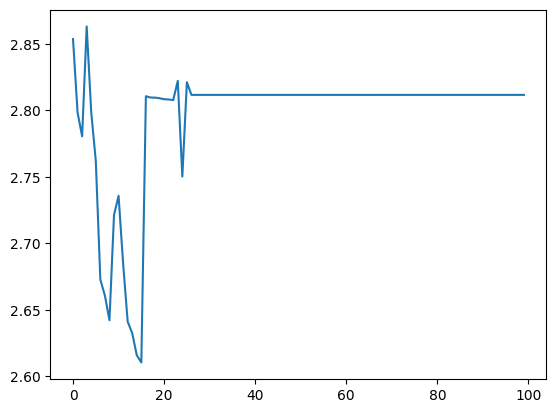

In [11]:
plt.plot(model.trainLoss)
plt.show()